In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
show = cv2_imshow

## **DiseasedPartOnly**

In [ ]:
def clustering(image):
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    k = 4
    ret, labels, (centers) = cv2.kmeans(pixel_values, k, None,
                                        criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    labels = labels.flatten()
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)

    clusters = []
    for cluster in range(k):
        masked_image = np.copy(image)
        for idx in range(k):
            if cluster != idx:
                masked_image = masked_image.reshape((-1, 3))
                masked_image[labels == idx] = [0, 0, 0]
        masked_image = masked_image.reshape(image.shape)
        clusters.append(masked_image)
        # plt.imshow(masked_image)
        # plt.show()
    return clusters


def sqrt_err(cluster):
    h, l, s = cv2.split(cluster)
    a1, a2, a3 = h[np.nonzero(h)].mean(), l[np.nonzero(l)].mean(), s[np.nonzero(s)].mean()
    x = [33.707906395033454, 138.86106172020976, 144.61589868000723]
    y = [a1, a2, a3]
    MSE = np.square(np.subtract(x, y)).mean()
    return MSE


def cluster_segmentation(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    clusters = clustering(image)
    errors = []
    for cluster in clusters:
        errors.append(sqrt_err(cluster))
    min_err = min(errors)
    desired_label = 0
    for i in range(len(errors)):
        if errors[i] == min_err:
            desired_label = i
    desired_cluster = clusters[desired_label]
    desired_cluster = cv2.cvtColor(desired_cluster, cv2.COLOR_HLS2BGR)
    # cv2.imshow('cluster_output', desired_cluster)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return desired_cluster
    #lab = cv2.cvtColor(masked_image, cv2.COLOR_BGR2LAB)


def obtain_final_threshold(img, inTh):
    count = 0
    a1, a2 = 0, 0
    n1, n2 = 1, 1
    nonzero_img = img[np.nonzero(img)]
    while True:
        for pixel_value in nonzero_img:
            if pixel_value < inTh:
                a1+=pixel_value
                n1+=1
            else:
                a2+=pixel_value
                n2+=1
        thresh = ((a1/n1) + (a2/n2))/2
        if abs(round(inTh) - round(thresh)) < 2 or count > 10:
            break
        count+=1

    return round(thresh)


def threshold_segmentation(image):
    # cv2.imshow('original_image', image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    cluster_image = cluster_segmentation(image)
    # cv2.imshow('cluster_output', cluster_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    lab = cv2.cvtColor(cluster_image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    # cv2.imshow('A_output', a)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    inTh = a[np.nonzero(a)].mean()
    try:
        thresh = obtain_final_threshold(a, inTh)
    except:
        thresh = inTh
    mask = cv2.threshold(a, thresh, 255, cv2.THRESH_BINARY)[1]
    segmented_image = cv2.bitwise_and(cluster_image, cluster_image, mask=mask)
    # cv2.imshow('segmented_output', segmented_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return segmented_image


def hole_fill(segmented_image, image):
    gray_segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)
    th, im_th = cv2.threshold(gray_segmented_image, 0, 255, cv2.THRESH_BINARY)
    im_floodfill = im_th.copy()
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0, 0), 255)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    im_out = im_th | im_floodfill_inv
    out_img = cv2.bitwise_and(image, image, mask=im_out)
    return out_img

## **ComponentLabelling**

- Took the diseased part of the leaf and converted it into HSL format

- Used the 'S' channel, to make the binary image

- Labelled the connected components in the binary image

- Displayed each connected component along with their mean 'S' values

In [ ]:
def bfs(row, col, bin, sImg, vis, labels, curLabel, dic):
    queue = []
    vis[row][col] = 1

    queue.insert(0, [row, col])

    cellsInComponent = []

    while (len(queue)):
        lst = queue.pop()
        poppedR, poppedC = lst[0], lst[1]

        i = [-1, 0, 1, 1, 1, 0, -1, -1]
        j = [-1, -1, -1, 0, 1, 1, 1, 0]

        for ii in range(0, 8):
            nbrI = poppedR + i[ii]
            nbrJ = poppedC + j[ii]

            if (nbrI >= 0 and nbrI < bin.shape[0] and nbrJ >= 0 and nbrJ < bin.shape[1]):
                if (bin[nbrI][nbrJ] == 255 and vis[nbrI][nbrJ] == 0):
                    vis[nbrI][nbrJ] = 1
                    queue.insert(0, [nbrI, nbrJ])
                    cellsInComponent.append([nbrI, nbrJ])

    if (len(cellsInComponent) >= 15):
        sum = 0
        copy = np.zeros((bin.shape[0], bin.shape[1]))

        for id in range(0, len(cellsInComponent)):
            labels[cellsInComponent[id][0]][cellsInComponent[id][1]] = curLabel[0]
            copy[cellsInComponent[id][0]][cellsInComponent[id][1]] = 255
            sum += sImg[cellsInComponent[id][0]][cellsInComponent[id][1]]

        mean = sum / len(cellsInComponent)

        dic[curLabel[0]] = [copy, mean]
        curLabel[0] += 45


def f(image): # give 's' of hls as an input
    binary = np.zeros((image.shape[0], image.shape[1]))
    vis = np.zeros((image.shape[0], image.shape[1]))
    labels = np.zeros((image.shape[0], image.shape[1]), dtype = np.uint64)

    for i in range(0, image.shape[0]):
        for j in range(0, image.shape[1]):
            if (image[i][j] != 0):
                binary[i][j] = 255

    print("The binary image :- ")
    show(binary)
    print("\n")

    curLabel = [30]
    dic = {}

    for iD in range(0, binary.shape[0]):
        for jD in range(0, binary.shape[1]):
            if (binary[iD][jD] == 255 and vis[iD][jD] == 0):
                bfs(iD, jD, binary, image, vis, labels, curLabel, dic)

    print(f"The image with all {len(dic)} components combined :- ")
    show(labels)
    print("\n")

    cc = 1
    for key in dic:
        print(f"Component {cc} with mean {dic[key][1]}")
        show(dic[key][0])
        print("\n")
        cc += 1

In [ ]:
def ff(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (256, 256))
    print("Original image :-")
    show(img)
    print("\n")

    segmented_image = threshold_segmentation(img)
    holeFill_image = hole_fill(segmented_image, img)
    show(holeFill_image)
    print("\n")

    hls = cv2.cvtColor(holeFill_image, cv2.COLOR_BGR2HLS)
    h, l, s = cv2.split(hls)
    print("'S' channel :-")
    show(s)
    print("\n")

    f(s)

## Image1(Tungro0399)

Original image :-


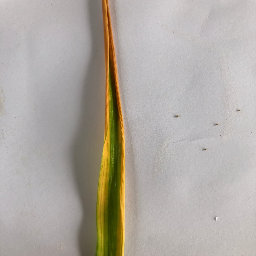

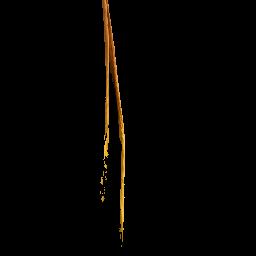



'S' channel :-


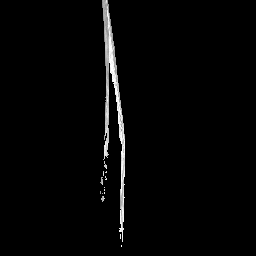



The binary image :- 


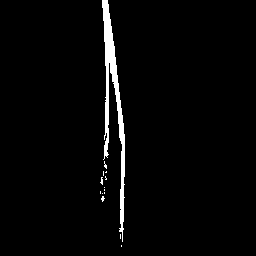



The image with all 1 components combined :- 


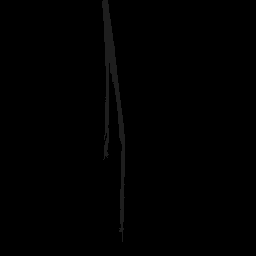



Component 1 with mean 204.15940224159402


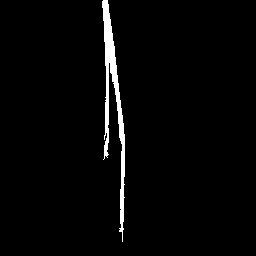

In [ ]:
ff("/content/drive/MyDrive/rice_dataset/tungro/IMG_0399.jpg")

## Image2(Tungro0903)

Original image :-


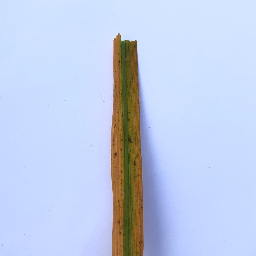

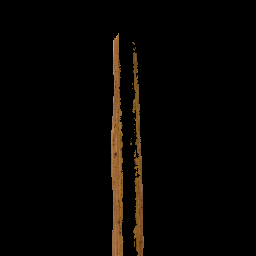



'S' channel :-


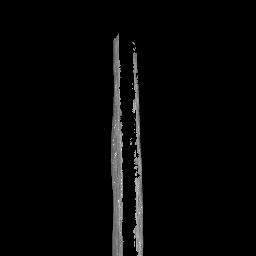



The binary image :- 


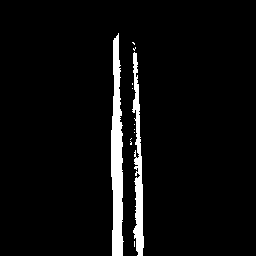



The image with all 2 components combined :- 


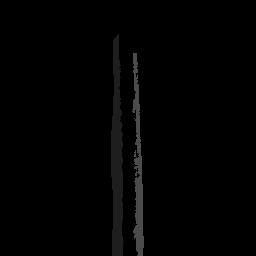



Component 1 with mean 124.91870324189526


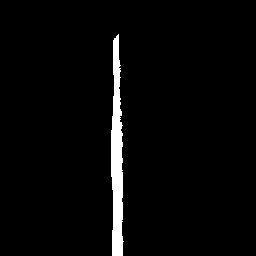



Component 2 with mean 137.8158783783784


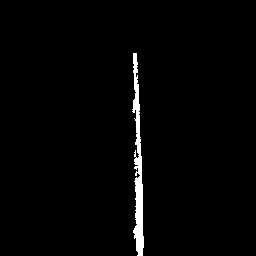

In [ ]:
ff("/content/drive/MyDrive/rice_dataset/tungro/IMG_0903.jpg")

## Image3(Tungro0833)

Original image :-


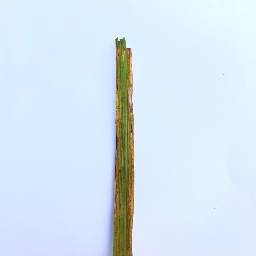

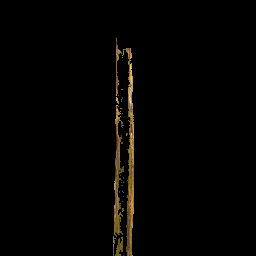



'S' channel :-


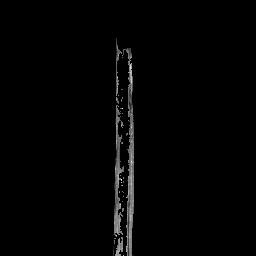



The binary image :- 


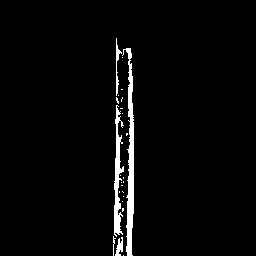



The image with all 5 components combined :- 


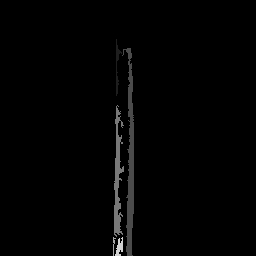



Component 1 with mean 102.82608695652173


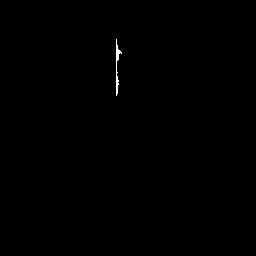



Component 2 with mean 117.71333964049195


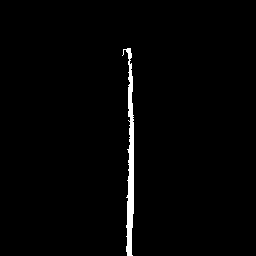



Component 3 with mean 114.41521394611728


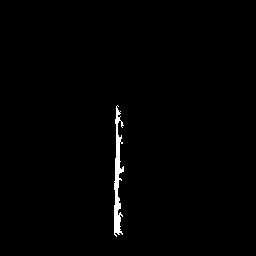



Component 4 with mean 48.333333333333336


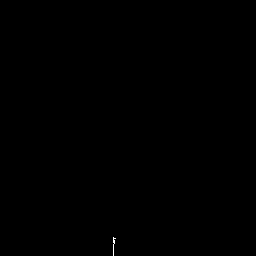



Component 5 with mean 140.5505617977528


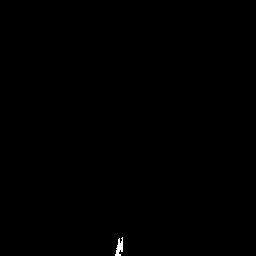

In [ ]:
ff("/content/drive/MyDrive/rice_dataset/tungro/IMG_0833.jpg")

## Image4(Tungro0583)

Original image :-


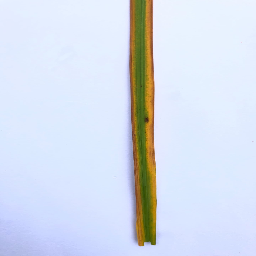

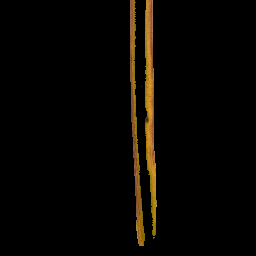



'S' channel :-


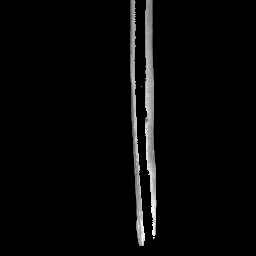



The binary image :- 


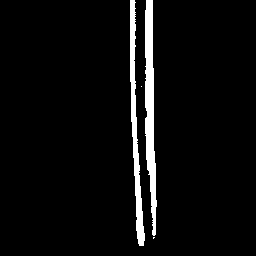



The image with all 2 components combined :- 


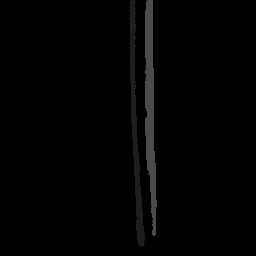



Component 1 with mean 154.34692364714604


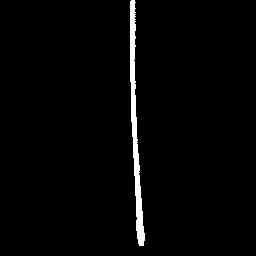



Component 2 with mean 166.13922588099365


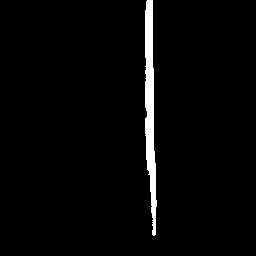

In [ ]:
ff("/content/drive/MyDrive/rice_dataset/tungro/IMG_0583.jpg")

## Image5(Tungro0850)

Original image :-


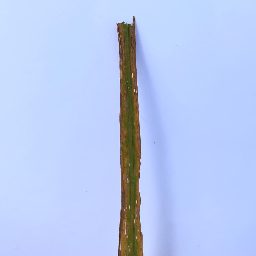

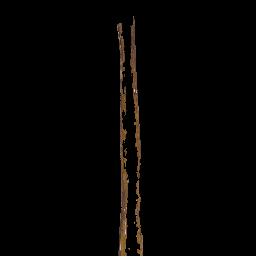



'S' channel :-


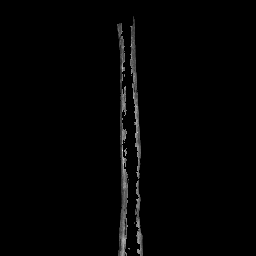



The binary image :- 


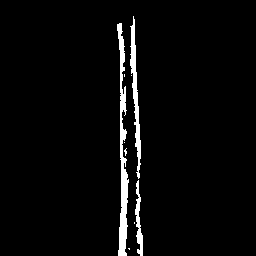



The image with all 3 components combined :- 


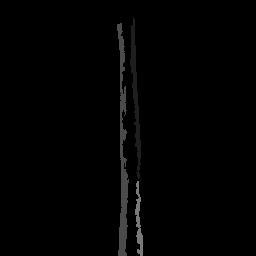



Component 1 with mean 98.3218045112782


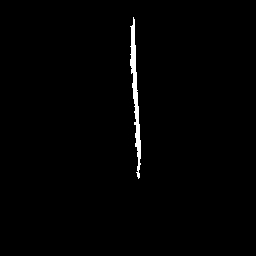



Component 2 with mean 93.41489361702128


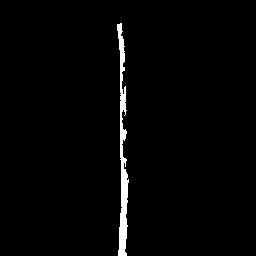



Component 3 with mean 106.01034482758621


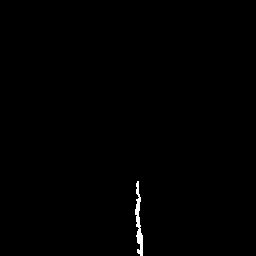

In [ ]:
ff("/content/drive/MyDrive/rice_dataset/tungro/IMG_0850.jpg")

## Image6(Tungro706)

Original image :-


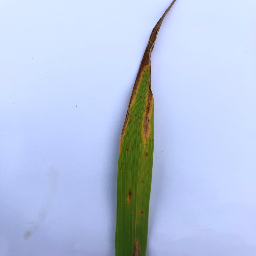

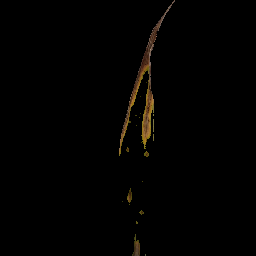



'S' channel :-


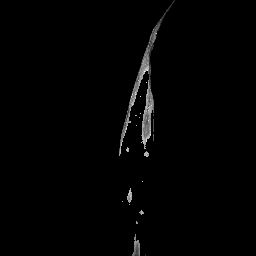



The binary image :- 


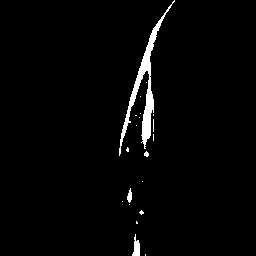



The image with all 4 components combined :- 


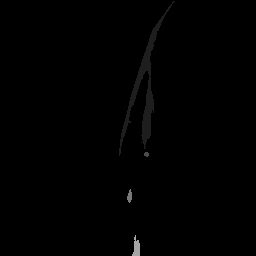



Component 1 with mean 120.62611516626116


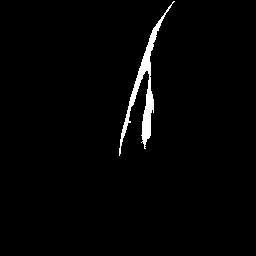



Component 2 with mean 174.05


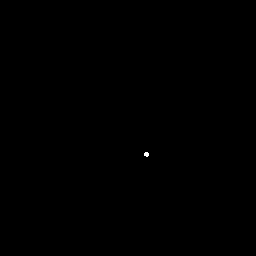



Component 3 with mean 169.93617021276594


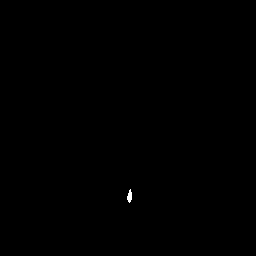



Component 4 with mean 111.70476190476191


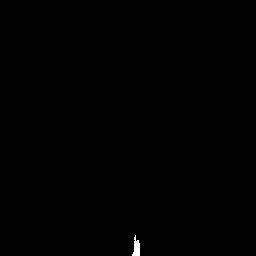

In [ ]:
ff("/content/drive/MyDrive/rice_dataset/tungro/IMG_0706.jpg")

## Image7(Tungro0868)

Original image :-


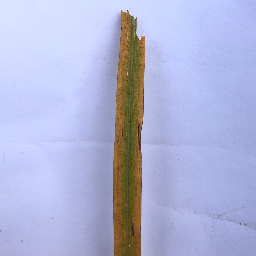

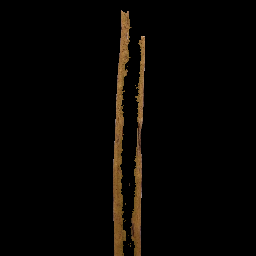



'S' channel :-


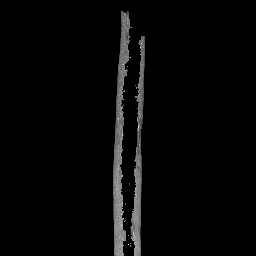



The binary image :- 


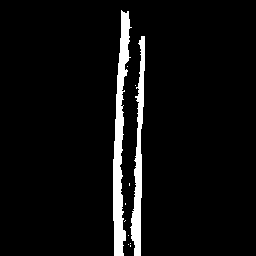



The image with all 2 components combined :- 


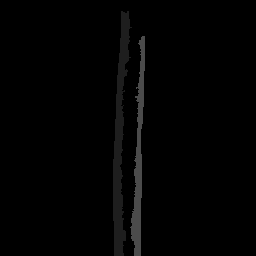



Component 1 with mean 122.43231649189704


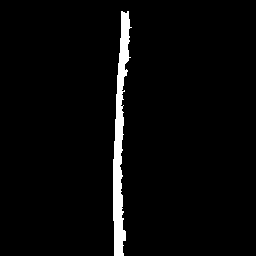



Component 2 with mean 115.66233766233766


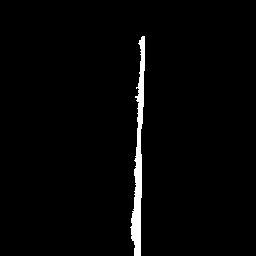

In [ ]:
ff("/content/drive/MyDrive/rice_dataset/tungro/IMG_0868.jpg")

## Image8(Tungro0903)

Original image :-


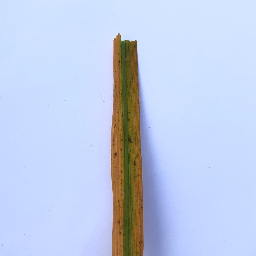

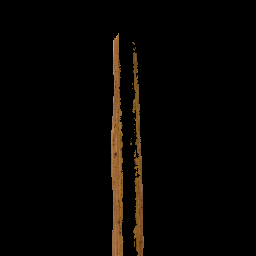



'S' channel :-


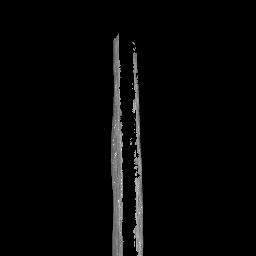



The binary image :- 


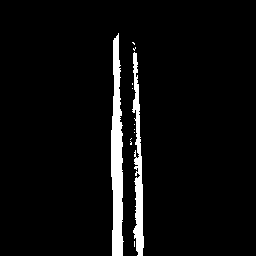



The image with all 2 components combined :- 


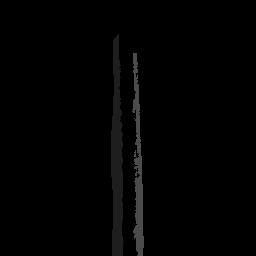



Component 1 with mean 124.91870324189526


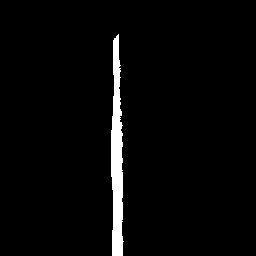



Component 2 with mean 137.8158783783784


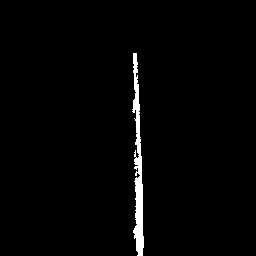

In [ ]:
ff("/content/drive/MyDrive/rice_dataset/tungro/IMG_0903.jpg")